In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
df = pd.read_excel('./Data/File1.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 28 columns):
Account Number        42 non-null int64
PortID                42 non-null object
Remaining Balance     42 non-null float64
interests Fees        42 non-null float64
Date Opened           42 non-null datetime64[ns]
Charge Off Date       42 non-null datetime64[ns]
Last Pay Date         38 non-null datetime64[ns]
Last Pay Amount       42 non-null float64
Last Activity Date    42 non-null datetime64[ns]
Interest Rate %       42 non-null float64
Issuer                42 non-null object
Merchant              42 non-null object
FCFRA Date            42 non-null datetime64[ns]
OOS Date              42 non-null datetime64[ns]
Account Type          42 non-null object
Last Name             42 non-null object
First Name            42 non-null object
Middle Name           28 non-null object
Address               42 non-null object
City                  42 non-null object
State                 42 n

- As the interest rate increases by 1% the odds of them paying back decrease by 84%

In [4]:
# Dummy up the Cycle as this is an important feature

df = pd.get_dummies(df, columns = ['Cycle'])
df.head()

,Account Number,PortID,Remaining Balance,interests Fees,Date Opened,Charge Off Date,Last Pay Date,Last Pay Amount,Last Activity Date,Interest Rate %,...,State,Zip,County,SSN,Home Phone,Employer Phone,Paid,Cycle_QUATERNARY,Cycle_SECONDARY,Cycle_TERTIARY
0,4071580080012050,FUS0813,6020.73,1352.43,1989-10-17,2005-12-30,NaT,200.0,2006-06-28,0.0800,...,CO,80203-4205,DENVER,287567934,3039418940,3036752373,0,0,0,1
1,4253294210011880,FUS0739,778.20,160.41,2005-06-03,2006-03-31,NaT,0.0,2005-06-03,0.0800,...,CO,80011-9052,ADAMS,523755675,3036800451,3036803635,0,0,0,1
2,4266493601904600,FUS0422,404.68,711.87,1995-09-01,2003-04-30,2002-09-08,0.0,2002-09-08,0.1924,...,CO,80221-2732,ADAMS,523710822,3034879164,9999999999,0,0,1,0
3,4266513023392740,FUS0560,502.26,718.72,1999-11-17,2003-12-31,2003-08-07,0.0,2003-08-07,0.1999,...,CO,80206-3522,DENVER,522234200,3036980983,9999999999,0,0,0,1
4,4266812001671530,FUS0722,6482.89,1654.38,1998-09-13,2005-09-30,2005-02-10,150.0,2005-02-10,0.0800,...,CO,80229-7910,ADAMS,522533406,3032875899,3032886677,0,0,0,1


In [5]:
num_cols = df.columns[[np.issubdtype(dt, np.number) for dt in df.dtypes]]

drop_cols = [key for key in dict(df.dtypes) 
                if dict(df.dtypes)[key] in ['datetime64[ns]', 'object']]

# Add Paid to drop list
drop_cols.append('Paid')

In [6]:
y = df['Paid']
X = df.drop(columns = drop_cols)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Fitting and making predictions with the Logistic Regression model.

---

In [8]:
# Step 1: Instantiate our model.
logreg = LogisticRegression()

# Step 2: Fit our model.
logreg.fit(X_train, y_train)

print('Logreg intercept:', logreg.intercept_)
print('Logreg coef(s):', logreg.coef_)

Logreg intercept: [-8.34348486e-32]
Logreg coef(s): [[-3.95109348e-16 -4.34541235e-28  2.73134005e-28 -3.61542562e-30
  -6.39757007e-33 -1.07901563e-22 -3.11324667e-22 -7.34090371e-22
   3.38797363e-32 -1.87794669e-32 -9.85351180e-32]]


In [9]:
y_pred = logreg.predict(X_test)
print('Logreg predicted:', y_pred)

Logreg predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0]


### Confusion Matrix

In [10]:
metrics.confusion_matrix(y_test, y_pred)

array([[12,  0],
       [ 1,  0]])

In [11]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 12
False Positives: 0
False Negatives: 1
True Positives: 0


#### Confusion Matrix Evaluation Metrics
Let's evaluate the model using model evaluation metrics such as accuracy, precision, and recall.

- Well, you got a classification rate of 92%, considered as good accuracy.

- Precision: Precision is about being precise, i.e., how accurate your model is. In other words, you can say, when a model makes a prediction, how often it is correct. In your prediction case, when your Logistic Regression model predicted debtors will pay back 0%, of the time.

- Recall: If there are debtors who pay back in the test set and your Logistic Regression model can identify it 0% of the time.



In [12]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9230769230769231
Precision: 0.0
Recall: 0.0


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

- AUC score for the case is 0.5. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

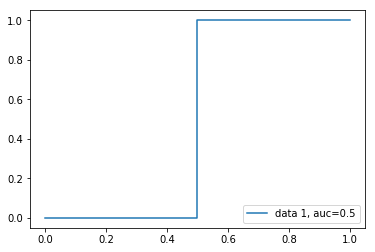

In [13]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Fitting and making predictions with DecisionTreeClassifier model.

---

In [15]:
# criterion: splitting decision function, can be 'gini' or 'entropy'
# max_depth: the maximum number of hierarchical decision nodes(how "deep" the tree is 
# built)

classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=None)

classifier.fit(X, y)

Y_pred = classifier.predict(X)

# decision trees can give us feature importances. the higher the number the more important
# the predictor was to deciding splits at nodes.
# "The importance of a feature is computed as the (normalized) total reduction of the 
# criterion brought by that feature."
#
feature_importances = classifier.feature_importances_

In [16]:
feature_importances

array([0.        , 0.16717445, 0.44801342, 0.20432432, 0.        ,
       0.        , 0.        , 0.        , 0.1804878 , 0.        ,
       0.        ])

In [17]:
X.columns

Index(['Account Number', 'Remaining Balance', 'interests Fees',
       'Last Pay Amount', 'Interest Rate %', 'SSN', 'Home Phone',
       'Employer Phone', 'Cycle_QUATERNARY', 'Cycle_SECONDARY',
       'Cycle_TERTIARY'],
      dtype='object')

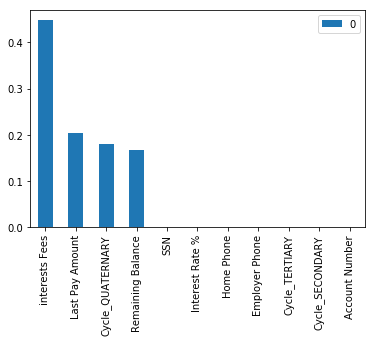

In [20]:
importances = list(zip(classifier.feature_importances_, X.columns))
importances.sort(reverse=True)

pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar')